# 1st-level Analysis of Localizer

Take the preprocessed output from fmriprep and template atlas to run for each subject a 1st-level analysis of localizer data. For this we need to do the following steps:

1. Extract onset times of stimuli from TSV file
2. Specify the model (TR, high pass filter, onset times, etc.)
3. Specify contrasts to compute
4. Estimate contrasts


### TODO

2. Check Contrasts
3. Autocorrelation method?
4. long-term: set to run from command line easier

## Setup

In [56]:
%matplotlib inline
import os
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node, MapNode
from bids.grabbids import BIDSLayout
from nipype import DataGrabber

def get_niftis(subject_id, data_dir, task):
    from bids.grabbids import BIDSLayout
    
    layout = BIDSLayout(data_dir)
    
    functional_runs = [f.filename for f in layout.get(subject=subject_id
                                            , task = task
                                            , type = "preproc"
                                            , extensions=['nii', 'nii.gz'])]
    
    return functional_runs

def subjectinfo(subject_id, bids_dir, run_list, output_dir):
    
    import pandas as pd
    from nipype.interfaces.base import Bunch
    import os
    
    subject_info = []
    trialinfo = pd.read_table(os.path.join(bids_dir, 
                                           'sub-{}'.format(subject_id), 
                                           'sub-{}_task-loc_events.tsv'.format(subject_id)))
    conditions = []
    onsets = []
    durations = []
    
    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset))
        durations.append(group[1].duration.tolist())

    for run in run_list:
        
        # the last 6 columns are the motion parameters
        regress = pd.read_table(os.path.join(output_dir,
                                             'fmriprep','sub-01','func',
                                             'sub-01_task-loc_run-{}_bold_confounds.tsv'.format(run))).iloc[:,-6:]
        
        subject_info.append(Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations,
                          #amplitudes=None,
                          #tmod=None,
                          #pmod=None,
                          regressor_names = list(regress),
                          regressors = regress.values.T.tolist()
                         ))
        
    return subject_info  # this output will later be returned to infosource

In [71]:
layout.get(subject = '01', task = "loc", extensions = ["nii"], type = "preproc")

[File(filename='/data/derivatives/scratch/l1analysis-con/_subject_id_01_task_id_loc/gunzip_con/mapflow/_gunzip_con0/sub-01_task-loc_run-01_bold_space-T1w_preproc.nii', task='loc', run='01', type='preproc', subject='01'),
 File(filename='/data/derivatives/scratch/l1analysis-con/_subject_id_01_task_id_loc/gunzip_con/mapflow/_gunzip_con1/sub-01_task-loc_run-02_bold_space-T1w_preproc.nii', task='loc', run='02', type='preproc', subject='01')]

## Experiment parameters

In [57]:
bids_dir = '/data'

layout = BIDSLayout(bids_dir)

output_dir = '/output'
spm_dir = os.path.join(output_dir, 'spm')
scratch_dir = os.path.join(output_dir, 'scratch')

# list of subject identifiers
subject_list = layout.get_subjects()[:1]
run_list = ['01','02']
task_list = 'loc'

# Condition names
condition_names = ['on']

# Contrasts
cont01 = ['on', 'T', condition_names, [1]]

contrast_list = [cont01]

## Specify Nodes

In [58]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition = 
                                 layout.get_metadata(layout.get(subject = "01", task = "loc",run = "01", modality = "func", type = "bold", return_type = "file")[1])['RepetitionTime'],
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 1]}},
                                 timing_units='secs',
                                 interscan_interval = 
                                 layout.get_metadata(layout.get(subject = "01", task = "loc",run = "01", modality = "func", type = "bold", return_type = "file")[1])['RepetitionTime'],
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), use_derivs=True, name="level1conest")

## Specify GLM Model

The next step is now to get information such as stimuli onset, duration and other regressors into the GLM model. For this we need to create a helper function, in our case called ``subjectinfo``.

In [59]:
# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id', 'bids_dir', 'run_list', 'output_dir'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')
getsubjectinfo.inputs.bids_dir = bids_dir
getsubjectinfo.inputs.run_list = run_list
getsubjectinfo.inputs.output_dir = output_dir

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [60]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]


BIDSDataGrabber = Node(Function(function=get_niftis,
                                input_names=["subject_id","data_dir", "task"],
                                output_names=["functional_runs"]), name="BIDSDataGrabber")
BIDSDataGrabber.inputs.data_dir = bids_dir
BIDSDataGrabber.inputs.task = task_list


# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory = spm_dir), name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_%s' % sub, 'sub-%s' % sub) for sub in subject_list]
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [61]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = os.path.join(bids_dir, scratch_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, getsubjectinfo, [('subject_id','subject_id')]),
                    (infosource, BIDSDataGrabber, [('subject_id','subject_id')]),
                    (BIDSDataGrabber, modelspec, [('functional_runs', 'functional_runs')]),
                    (getsubjectinfo, modelspec, [('subject_info','subject_info')]),
                    (modelspec, level1design, [('session_info','session_info')]),
                    (level1design, level1estimate, [('spm_mat_file','spm_mat_file')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (level1estimate, level1conest, [('spm_mat_file','spm_mat_file'),
                                                    ('beta_images', 'beta_images'),
                                                    ('residual_image','residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', 'loc1stLevel.@spm_mat'),
                                              ('spmT_images', 'loc1stLevel.@T'),
                                              ('con_images', 'loc1stLevel.@con'),
                                              ('ess_images', 'loc1stLevel.@ess'),
                                              ]),
                    ])

##  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [62]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 2})

180313-06:18:08,252 workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging']
180313-06:18:08,365 workflow INFO:
	 Running in parallel.
180313-06:18:08,374 workflow INFO:
	 Executing: BIDSDataGrabber.a0 ID: 0
180313-06:18:08,400 workflow INFO:
	 [Job finished] jobname: BIDSDataGrabber.a0 jobid: 0
180313-06:18:08,405 workflow INFO:
	 Executing: getsubjectinfo.a0 ID: 1
180313-06:18:08,419 workflow INFO:
	 [Job finished] jobname: getsubjectinfo.a0 jobid: 1
180313-06:18:08,424 workflow INFO:
	 Executing: modelspec.a0 ID: 2
180313-06:18:08,510 workflow ERROR:
	 ['Node modelspec.a0 failed to run on host 27d1832b1eca.']
180313-06:18:08,514 workflow INFO:
	 Saving crash info to /home/jovyan/work/data/code/workflows/crash-20180313-061808-jovyan-modelspec.a0-445c1912-f5ab-4c51-b01a-9a4aa3a8d1e1.pklz
180313-06:18:08,517 workflow INFO:
	 Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/site-packages/nipype/pipeline/plugins/multiproc.py", line 300, in _send

In [63]:
from nilearn.plotting import plot_stat_map
anatimg = os.path.join(output_dir,'fmriprep','sub-01','anat', 'sub-01_T1w_preproc.nii.gz' )
plot_stat_map(
    os.path.join(spm_dir,'loc1stLevel','sub-01', 'con_0001.nii'), title='Contrast',
    bg_img=anatimg, threshold=1, display_mode='y', cut_coords=(-90, -85, -80, -75, -70), dim=-1)
plot_stat_map(
    os.path.join(spm_dir,'loc1stLevel','sub-01', 'spmT_0001.nii'), title='SPM',
    bg_img=anatimg, threshold=1.64, display_mode='y', cut_coords=(-90, -85, -80, -75, -70), dim=-1)


/opt/conda/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


ValueError: File not found: '/output/spm/loc1stLevel/sub-01/con_0001.nii'

171214-01:36:17,919 workflow INFO:
	 Generated workflow graph: /output/scratch/l1analysis/graph.dot.png (graph2use=colored, simple_form=True).


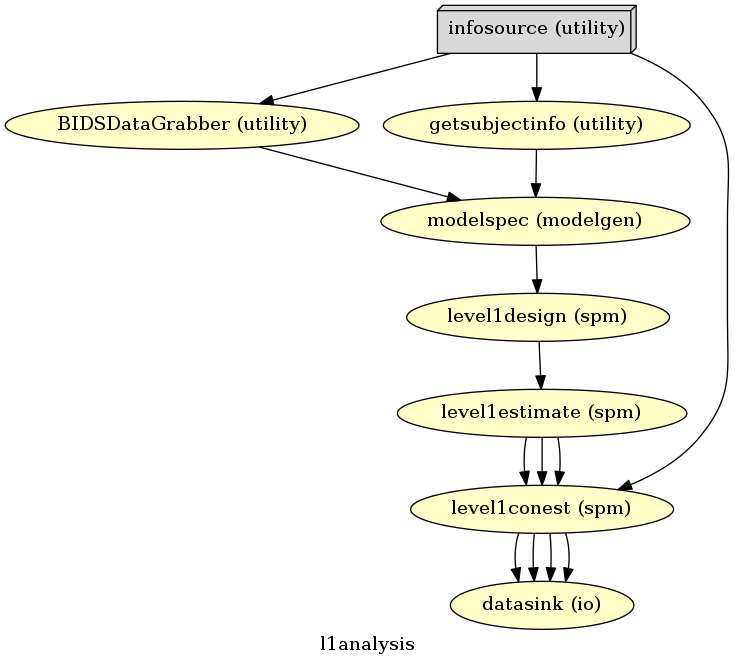

In [31]:
# # Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# # Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(l1analysis.base_dir, 'l1analysis', 'graph.dot.png'))